# Test de différents modèles

## Modèle Explicatif (Taux vs Facteurs Environnementaux/Économiques)

### 🔄 Améliorations par rapport à NbCorrected.ipynb :

1. **Imputation sophistiquée** : Utilisation de `IterativeImputer` (via `data_preparation.py`) au lieu de la simple médiane
   - Forward/backward fill par pays pour les séries temporelles
   - IterativeImputer pour les valeurs manquantes restantes (méthode plus robuste)

2. **Encodage automatique** : Les pays (`Country Code`) sont automatiquement encodés en one-hot lors de l'imputation

3. **Pas de SMOTE** : Pour l'instant, nous n'utilisons pas SMOTE (commenté) pour évaluer les performances sans sur-échantillonnage

4. **Architecture simplifiée** : Pas de pipeline imbriqué - les données sont pré-traitées avant la modélisation


In [1]:
# Définir le chemin de base
BASE_PATH = "/mnt/c/Users/ala78/OneDrive - HESSO/BA5/GML/data-gml-health/Refined"

# Définir le dossier
folder_name = "1021"

# Définir le nom du fichier
file_name = "COPD_prevalence_rate"

# Définir le format du fichier (csv, parquet, ...)
file_format = "csv"

In [2]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Ajouter le dossier parent au path pour importer data_preparation
project_root = Path.cwd().parent    
sys.path.append(str(project_root.resolve()))

import data_preparation

# Chargement des données (adaptez le chemin selon votre fichier)
df = pd.read_csv(f"{BASE_PATH}/{folder_name}/{file_name}.{file_format}")

# Affichage des premières lignes pour vérifier les noms de colonnes
print("Aperçu des données :")
print(df.head())
print("\nNoms des colonnes :")
print(df.columns.tolist())
print("\nTypes de données :")
print(df.dtypes)


Aperçu des données :
      Measure Country Name                                Disease Metric  \
0  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
1  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
2  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
3  Prevalence        China  Chronic obstructive pulmonary disease   Rate   
4  Prevalence        China  Chronic obstructive pulmonary disease   Rate   

   Year        Value Country Code  \
0  2015  1588.006576          IDN   
1  2017  1646.266156          IDN   
2  2018  1680.660819          IDN   
3  2013  3138.935866          CHN   
4  2014  3190.618304          CHN   

  Access to clean fuels and technologies for cooking (% of population)  \
0                                               67.3                     
1                                               75.5                     
2                                               78.9                     
3  

In [3]:
df.shape

(353, 38)

### Étape 1 : Création de la variable cible (Y)

Au lieu de prédire le *changement* (Augmente/Diminue), nous allons prédire le *niveau* du taux lui-même.
Nous divisons le taux `Value` en 3 catégories (quantiles) pour équilibrer les classes :
- 0 : Faible
- 1 : Moyen
- 2 : Élevé

In [4]:
# Utilisation de qcut pour diviser les données en 3 quantiles (tertiles)
# Cela garantit une distribution à peu près égale des classes
try:
    df['Y_class'] = pd.qcut(df['Value'], q=3, labels=[0, 1, 2])
    df['Y_label'] = pd.qcut(df['Value'], q=3, labels=['Faible', 'Moyen', 'Élevé'])
except ValueError as e:
    print(f"Avertissement lors du qcut : {e}. Il peut y avoir des valeurs dupliquées.")
    # En cas d'échec (par exemple, trop de valeurs identiques), on force
    df['Y_class'] = pd.qcut(df['Value'], q=3, labels=[0, 1, 2], duplicates='drop')
    df['Y_label'] = pd.qcut(df['Value'], q=3, labels=['Faible', 'Moyen', 'Élevé'], duplicates='drop')

print("✓ Variable cible 'Y_class' (0=Faible, 1=Moyen, 2=Élevé) créée.")
print("\nDistribution de la nouvelle variable cible :")
print(df['Y_label'].value_counts())

print("\nExemple de données avec la nouvelle cible :")
print(df[['Country Name', 'Year', 'Value', 'Y_class', 'Y_label']].head())

✓ Variable cible 'Y_class' (0=Faible, 1=Moyen, 2=Élevé) créée.

Distribution de la nouvelle variable cible :
Y_label
Faible    118
Élevé     118
Moyen     117
Name: count, dtype: int64

Exemple de données avec la nouvelle cible :
  Country Name  Year        Value Y_class Y_label
0    Indonesia  2015  1588.006576       0  Faible
1    Indonesia  2017  1646.266156       0  Faible
2    Indonesia  2018  1680.660819       0  Faible
3        China  2013  3138.935866       0  Faible
4        China  2014  3190.618304       0  Faible


### Étape 1.5 : Préparation et Imputation des Données

Nous allons utiliser les fonctions de `data_preparation.py` pour :
1. Préprocesser les données (remplacer '..' et 'nan' par NaN)
2. Imputer les valeurs manquantes avec la méthode IterativeImputer (plus sophistiquée que la médiane simple)


In [5]:
# Sauvegarder Y_class et Y_label avant l'imputation
y_class_saved = df['Y_class'].copy()
y_label_saved = df['Y_label'].copy()

# Définir uniquement les colonnes à EXCLURE
# (Ce sont les métadonnées et les cibles)
cols_to_exclude = [
    'Measure', 
    'Country Name', 
    'Disease', 
    'Metric', 
    'Y_class', 
    'Y_label'
]

# Sélectionner les colonnes pour l'imputation
df_for_imputation = df.drop(columns=cols_to_exclude).copy()

print("\n⏳ Étape 1/2 : Preprocessing (remplacement de '..' et 'nan' par NaN)...")
df_prepared = data_preparation.preprocessing(df_for_imputation)

print(f"Nombre de NaN après preprocessing :")
print(df_prepared.isnull().sum().sum())

print("\n⏳ Étape 2/2 : Imputation des valeurs manquantes avec IterativeImputer...")
print("⚠️ Cette étape peut prendre quelques minutes...")
df_imputed = data_preparation.impute_nans(df_prepared)

print("\n✓ Imputation terminée !")
print(f"Nombre de NaN après imputation : {df_imputed.isnull().sum().sum()}")

# Récupérer les index originaux et ajouter Y_class et Y_label
df_imputed.index = df.index
df_imputed['Y_class'] = y_class_saved
df_imputed['Y_label'] = y_label_saved

print("\n✓ Données préparées et imputées avec succès !")
print(f"Forme finale : {df_imputed.shape}")



⏳ Étape 1/2 : Preprocessing (remplacement de '..' et 'nan' par NaN)...
Nombre de NaN après preprocessing :
675

⏳ Étape 2/2 : Imputation des valeurs manquantes avec IterativeImputer...
⚠️ Cette étape peut prendre quelques minutes...
📊 Colonnes détectées pour l'imputation : 32 colonnes


/home/aladin/gml/GML_RespiratoryDiseases/data_preparation.py:70: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .transform(lambda g: g.ffill().bfill())



✓ Imputation terminée !
Nombre de NaN après imputation : 0

✓ Données préparées et imputées avec succès !
Forme finale : (353, 81)


In [6]:
df.shape

(353, 40)

### Étape 2 : Définition des Features (X)

Nous utilisons toutes les colonnes brutes (environnementales, économiques, etc.) pour expliquer `Y`. Nous n'utilisons **pas de décalage (lag)**, car nous recherchons une corrélation pour la *même année*.

**Note importante** : Après l'imputation avec `data_preparation.impute_nans()`, les colonnes `Country Code` ont été encodées en one-hot encoding (plusieurs colonnes `Country Code_XXX`). C'est pourquoi nous avons maintenant beaucoup plus de features qu'initialement.


In [7]:
# Définition des features (X) et de la cible (y)

# Définir les colonnes qui ne sont PAS des features
# (ce sont vos cibles et la cible d'origine)
cols_to_exclude = ['Value', 'Y_class', 'Y_label']

# features_for_model : toutes les colonnes SAUF les cibles, Year, et Country Code encodés
all_columns = df_imputed.drop(columns=cols_to_exclude).columns.tolist()

# Exclure Year et les colonnes Country Code_XXX pour éviter les biais
features_for_model = [col for col in all_columns 
                      if col != 'Year' and not col.startswith('Country Code_')]

print(f"📊 Filtrage des features :")
print(f"   Total de colonnes disponibles : {len(all_columns)}")
print(f"   Colonnes Country Code exclues : {sum(1 for col in all_columns if col.startswith('Country Code_'))}")
print(f"   Year exclu : {'Year' in all_columns}")
print(f"   Features finales pour modélisation : {len(features_for_model)}")

# Créer le DataFrame pour la modélisation (utiliser df_imputed au lieu de df)
df_model = df_imputed[features_for_model + ['Y_class']].copy()

# Nettoyer les NaN de la cible (s'il y en a eu lors du qcut)
df_model = df_model.dropna(subset=['Y_class'])

print(f"\n✓ Taille du DataFrame pour modélisation : {df_model.shape}")
print(f"✓ Nombre de NaN dans df_model : {df_model.isnull().sum().sum()}")
print(f"\n⚠️ Note : Year et Country Code ont été EXCLUS pour éviter les biais géographiques/temporels")


📊 Filtrage des features :
   Total de colonnes disponibles : 78
   Colonnes Country Code exclues : 46
   Year exclu : True
   Features finales pour modélisation : 31

✓ Taille du DataFrame pour modélisation : (353, 32)
✓ Nombre de NaN dans df_model : 0

⚠️ Note : Year et Country Code ont été EXCLUS pour éviter les biais géographiques/temporels


In [8]:
df_imputed.shape

(353, 81)

### Étape 3 : Configuration des Modèles

**Différence avec NbCorrected.ipynb** :
- ✅ Les données sont **déjà imputées** avec `IterativeImputer` (plus sophistiqué que la médiane)
- ✅ Pas besoin de pipeline `ImbPipeline` avec imputer/scaler/SMOTE
- ✅ Pour la Logistic Regression : standardisation des données (nécessaire pour ce modèle)
- ✅ Pour Random Forest et XGBoost : données brutes (ces modèles tree-based n'ont pas besoin de standardisation)
- ⚠️ SMOTE est désactivé pour l'instant (à réactiver si nécessaire)


In [9]:
# Import des bibliothèques pour SMOTE et classification
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("✓ Bibliothèques importées avec succès pour la classification multi-classe !")
print("="*80)


✓ Bibliothèques importées avec succès pour la classification multi-classe !


In [10]:
# Définition de X et y
X = df_model.drop('Y_class', axis=1)
y = df_model['Y_class'].astype(int)

# Vérifier que toutes les colonnes sont déjà numériques (après l'imputation)
print("Types de données dans X :")
print(X.dtypes.value_counts())

# Vérifier les NaN
print(f"\nNombre total de NaN dans X : {X.isnull().sum().sum()}")
if X.isnull().sum().sum() > 0:
    print("⚠️ Colonnes avec des NaN :")
    print(X.isnull().sum()[X.isnull().sum() > 0])

# Noms des features finales
feature_names = X.columns.tolist()
print(f"\n✓ {len(feature_names)} features prêtes pour la modélisation")

# Division Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"\nDistribution de la cible dans l'ensemble d'entraînement :")
print(y_train.value_counts(normalize=True))

print("\n✓ Données train/test prêtes (pas besoin de pipeline de prétraitement)")
print(f"   X_train shape : {X_train.shape}")
print(f"   X_test shape  : {X_test.shape}")


Types de données dans X :
float64    31
Name: count, dtype: int64

Nombre total de NaN dans X : 0

✓ 31 features prêtes pour la modélisation

Distribution de la cible dans l'ensemble d'entraînement :
Y_class
0    0.333333
2    0.333333
1    0.333333
Name: proportion, dtype: float64

✓ Données train/test prêtes (pas besoin de pipeline de prétraitement)
   X_train shape : (282, 31)
   X_test shape  : (71, 31)


In [11]:
X.shape

(353, 31)

In [12]:
# Définition des 3 modèles pour CLASSIFICATION MULTI-CLASSE

print("="*80)
print("CONFIGURATION DES MODÈLES POUR CLASSIFICATION MULTI-CLASSE (3 CLASSES)")
print("="*80)

# Les données sont déjà imputées et prétraitées, nous n'avons plus besoin de pipeline
# Pour la Logistic Regression, nous allons quand même standardiser
from sklearn.preprocessing import StandardScaler

# Pour Logistic Regression : on va standardiser
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models_with_smote = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        multi_class='auto' # Gère les 3 classes
    ),
    
    'Random Forest': RandomForestClassifier(
        random_state=42, 
        n_estimators=100
    ),
    
    'XGBoost': XGBClassifier(
        objective='multi:softmax',  # Objectif multi-classe
        num_class=3,              # Nombre de classes
        random_state=42, 
        eval_metric='mlogloss'
    )
}

print("\n✓ Modèles créés pour 3 classes :")
for model_name in models_with_smote.keys():
    print(f"  - {model_name}")
    
print("\n⚠️ Note : Les données sont déjà imputées avec IterativeImputer")
print("   Logistic Regression utilisera des données standardisées")
print("   Random Forest et XGBoost utiliseront les données brutes")
print("="*80)


CONFIGURATION DES MODÈLES POUR CLASSIFICATION MULTI-CLASSE (3 CLASSES)

✓ Modèles créés pour 3 classes :
  - Logistic Regression
  - Random Forest
  - XGBoost

⚠️ Note : Les données sont déjà imputées avec IterativeImputer
   Logistic Regression utilisera des données standardisées
   Random Forest et XGBoost utiliseront les données brutes


### Étape 4 : Entraînement et Évaluation des Modèles

In [13]:
# Dictionnaire pour stocker les résultats
results_with_smote = {}

print("="*80)
print("ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES - (3 CLASSES)")
print("="*80)

# Labels des classes pour les rapports
class_labels = ['Faible (0)', 'Moyen (1)', 'Élevé (2)']

for model_name, model in models_with_smote.items():
    print(f"\n{'='*80}")
    print(f"🔄 Modèle : {model_name}")
    print('='*80)
    
    # Entraînement
    print(f"⏳ Entraînement en cours...")
    
    # Logistic Regression utilise les données standardisées
    if model_name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        # Random Forest et XGBoost utilisent les données brutes
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    print(f"✓ Entraînement terminé")
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    # Utiliser 'weighted' pour F1, Precision, Recall pour la moyenne globale
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Stockage des résultats
    results_with_smote[model_name] = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'y_pred': y_pred
    }
    
    # Affichage des métriques globales
    print(f"\n📊 Métriques globales (pondérées) :")
    print(f"   Accuracy  : {accuracy:.4f}")
    print(f"   Precision : {precision:.4f}")
    print(f"   Recall    : {recall:.4f}")
    print(f"   F1-Score  : {f1:.4f}")
    
    # Rapport de classification détaillé pour les 3 classes
    print(f"\n📋 Rapport de Classification (3 classes) :")
    print(classification_report(y_test, y_pred, 
                                target_names=class_labels,
                                zero_division=0))

print(f"\n{'='*80}")
print("✓ Tous les modèles ont été entraînés et évalués sur 3 classes !")
print('='*80)


ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES - (3 CLASSES)

🔄 Modèle : Logistic Regression
⏳ Entraînement en cours...
✓ Entraînement terminé

📊 Métriques globales (pondérées) :
   Accuracy  : 0.5211
   Precision : 0.5380
   Recall    : 0.5211
   F1-Score  : 0.5234

📋 Rapport de Classification (3 classes) :
              precision    recall  f1-score   support

  Faible (0)       0.67      0.50      0.57        24
   Moyen (1)       0.48      0.48      0.48        23
   Élevé (2)       0.47      0.58      0.52        24

    accuracy                           0.52        71
   macro avg       0.54      0.52      0.52        71
weighted avg       0.54      0.52      0.52        71


🔄 Modèle : Random Forest
⏳ Entraînement en cours...
✓ Entraînement terminé

📊 Métriques globales (pondérées) :
   Accuracy  : 0.7887
   Precision : 0.8012
   Recall    : 0.7887
   F1-Score  : 0.7915

📋 Rapport de Classification (3 classes) :
              precision    recall  f1-score   support

  Faible (0)       

/home/aladin/.gml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✓ Entraînement terminé

📊 Métriques globales (pondérées) :
   Accuracy  : 0.7183
   Precision : 0.7299
   Recall    : 0.7183
   F1-Score  : 0.7194

📋 Rapport de Classification (3 classes) :
              precision    recall  f1-score   support

  Faible (0)       0.84      0.67      0.74        24
   Moyen (1)       0.69      0.78      0.73        23
   Élevé (2)       0.65      0.71      0.68        24

    accuracy                           0.72        71
   macro avg       0.73      0.72      0.72        71
weighted avg       0.73      0.72      0.72        71


✓ Tous les modèles ont été entraînés et évalués sur 3 classes !


### Étape 5 : Matrices de Confusion

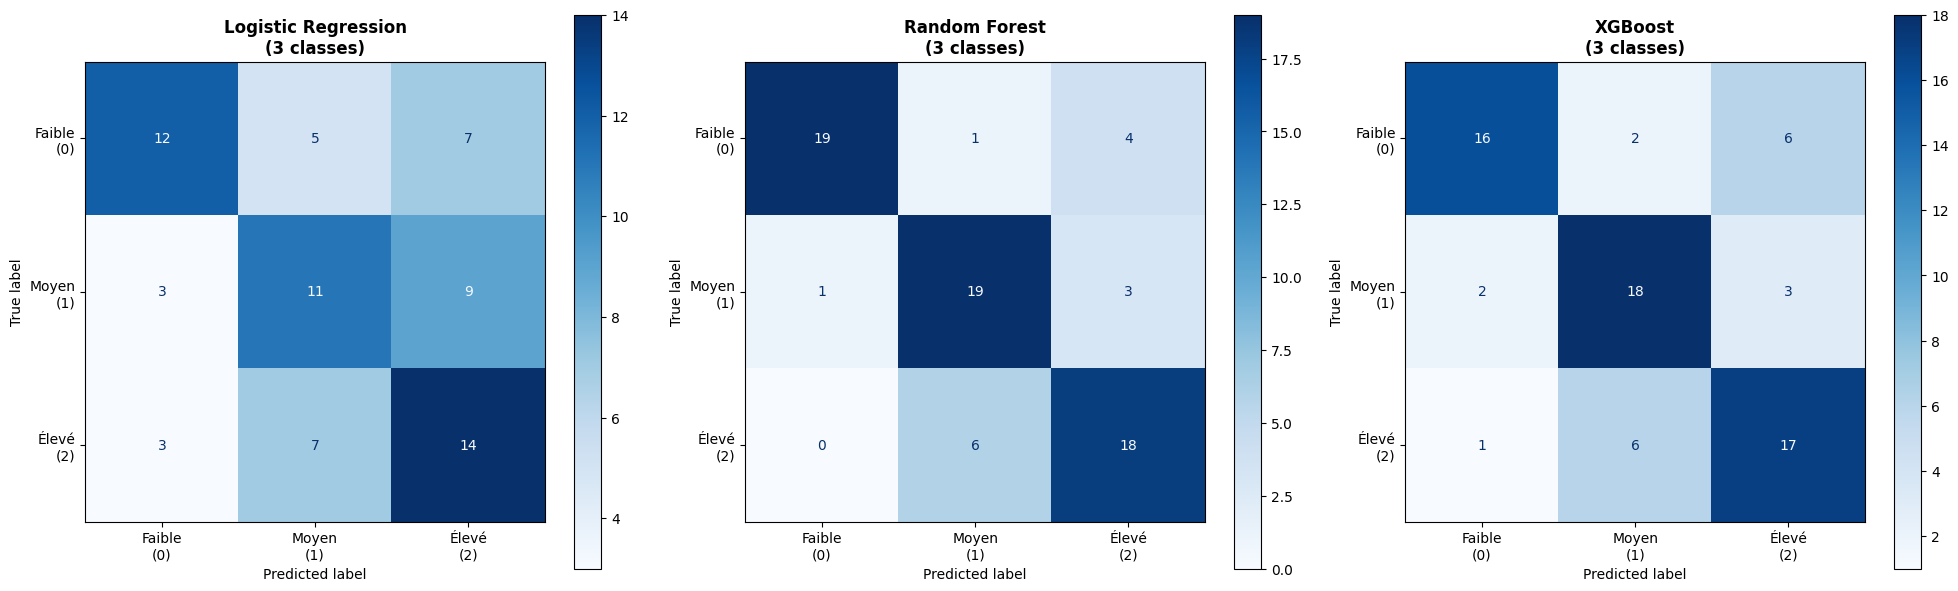

✓ Matrices de confusion affichées pour les 3 classes


In [14]:
# Affichage des matrices de confusion pour les 3 modèles (3 CLASSES)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Labels pour les 3 classes
display_labels = ['Faible\n(0)', 'Moyen\n(1)', 'Élevé\n(2)']

for idx, (model_name, results) in enumerate(results_with_smote.items()):
    y_pred = results['y_pred']
    
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    
    # Affichage
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=display_labels
    )
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{model_name}\n(3 classes)', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(False)

plt.tight_layout()
plt.show()

print("✓ Matrices de confusion affichées pour les 3 classes")
print("="*80)


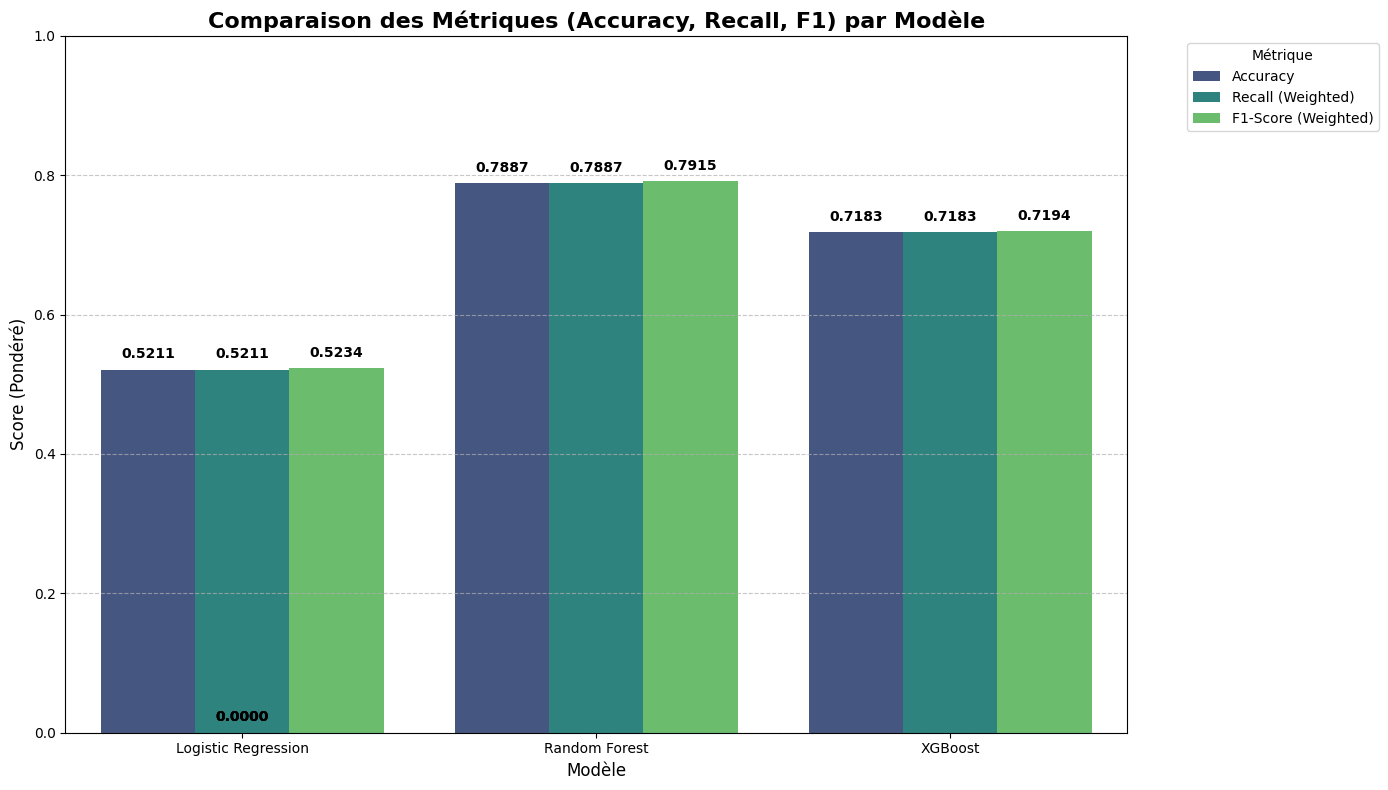

Graphique de comparaison des métriques généré et sauvegardé sous 'model_metrics_comparison.png'


In [15]:
# 1. Extraire les données de 'results_with_smote' (créé dans la cellule 40)
# Assurez-vous que la cellule 40 a été exécutée.
data_list = []
for model_name, metrics in results_with_smote.items():
    data_list.append({
        'Modèle': model_name,
        'Accuracy': metrics['accuracy'],
        'Recall (Weighted)': metrics['recall_weighted'],
        'F1-Score (Weighted)': metrics['f1_weighted']
    })

# 2. Convertir en DataFrame
df_results = pd.DataFrame(data_list)

# 3. Mettre en format long (melt) pour Seaborn
df_melted = df_results.melt(id_vars='Modèle', var_name='Métrique', value_name='Score')

# 4. Créer le graphique à barres groupées
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=df_melted,
    x='Modèle',
    y='Score',
    hue='Métrique',
    palette='viridis'
)

# 5. Améliorer la lisibilité
plt.title('Comparaison des Métriques (Accuracy, Recall, F1) par Modèle', fontsize=16, fontweight='bold')
plt.ylabel('Score (Pondéré)', fontsize=12)
plt.xlabel('Modèle', fontsize=12)

# Forcer l'axe Y à commencer à 0 et finir à 1 pour respecter les proportions.
plt.ylim(0, 1)

# Ajouter les étiquettes de données (placées légèrement au-dessus des barres)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.4f}', # 4 décimales
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        xytext=(0, 6),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold'
    )

plt.legend(title='Métrique', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# Sauvegarder le graphique
plt.savefig("model_metrics_comparison.png")
plt.show()

print("Graphique de comparaison des métriques généré et sauvegardé sous 'model_metrics_comparison.png'")

## Étape 6 : Analyse de l'Importance des Features

Maintenant, nous pouvons voir quels facteurs (économiques, environnementaux, etc.) ont le plus d'influence sur la prédiction du taux de BPCO.

In [16]:
# Extraction de l'importance des features pour chaque modèle

print("="*100)
print("ANALYSE DE L'IMPORTANCE DES FEATURES (MODÈLE EXPLICATIF)")
print("="*100)

# Dictionnaire pour stocker les importances
feature_importances = {}

# Noms des features utilisées
print(f"\nFeatures analysées : {len(feature_names)} features\n")

# Pour chaque modèle, extraire l'importance des features
for model_name, model in models_with_smote.items():
    print(f"\n{'='*100}")
    print(f"📊 {model_name}")
    print('='*100)
    
    # Récupérer directement le modèle (plus de pipeline)
    if model_name == 'Logistic Regression':
        # Pour la régression logistique multi-classe, on prend la moyenne des coeffs absolus
        importances = np.abs(model.coef_).mean(axis=0)
        method = "Moyenne des valeurs absolues des coefficients (multi-classe)"
        
    elif model_name == 'Random Forest':
        importances = model.feature_importances_
        method = "Feature importances (Gini importance)"
        
    elif model_name == 'XGBoost':
        importances = model.feature_importances_
        method = "Feature importances (gain)"
    
    # Vérification de la correspondance des dimensions
    print(f"\nNombre de features dans X_train : {len(feature_names)}")
    print(f"Nombre d'importances retournées : {len(importances)}")
    
    # S'assurer que les dimensions correspondent
    if len(importances) != len(feature_names):
        print(f"⚠️ ATTENTION : Désalignement détecté !")
        print(f"   Ajustement automatique...")
        # Utiliser seulement les features qui existent
        min_len = min(len(importances), len(feature_names))
        importances = importances[:min_len]
        current_feature_names = feature_names[:min_len]
    else:
        current_feature_names = feature_names
    
    # Stocker les importances
    feature_importances[model_name] = importances
    
    # Créer un DataFrame pour un affichage plus lisible
    importance_df = pd.DataFrame({
        'Feature': current_feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"\nMéthode utilisée : {method}")
    print(f"\n{'Feature':<65} {'Importance':>15} {'Importance %':>15}")
    print("-" * 100)
    
    total_importance = importances.sum()
    for idx, row in importance_df.iterrows():
        pct = (row['Importance'] / total_importance) * 100
        print(f"{row['Feature']:<65} {row['Importance']:>15.6f} {pct:>14.2f}%")
    
    # Top 5 features
    print(f"\n🏆 Top 5 features les plus importantes :")
    for i, row in enumerate(importance_df.head(5).iterrows(), 1):
        idx, data = row
        pct = (data['Importance'] / total_importance) * 100
        print(f"   {i}. {data['Feature']} ({pct:.2f}%)")

print(f"\n{'='*100}")
print("✓ Analyse de l'importance des features terminée")
print("="*100)


ANALYSE DE L'IMPORTANCE DES FEATURES (MODÈLE EXPLICATIF)

Features analysées : 31 features


📊 Logistic Regression

Nombre de features dans X_train : 31
Nombre d'importances retournées : 31

Méthode utilisée : Moyenne des valeurs absolues des coefficients (multi-classe)

Feature                                                                Importance    Importance %
----------------------------------------------------------------------------------------------------
Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)        0.993705           8.62%
Life expectancy at birth, total (years)                                  0.775680           6.73%
Mortality rate, infant (per 1,000 live births)                           0.720768           6.25%
GDP per capita (constant 2015 US$)                                       0.707290           6.13%
Share of population who are daily smokers (Pct population)               0.582291           5.05%
Total area (Square Km)        

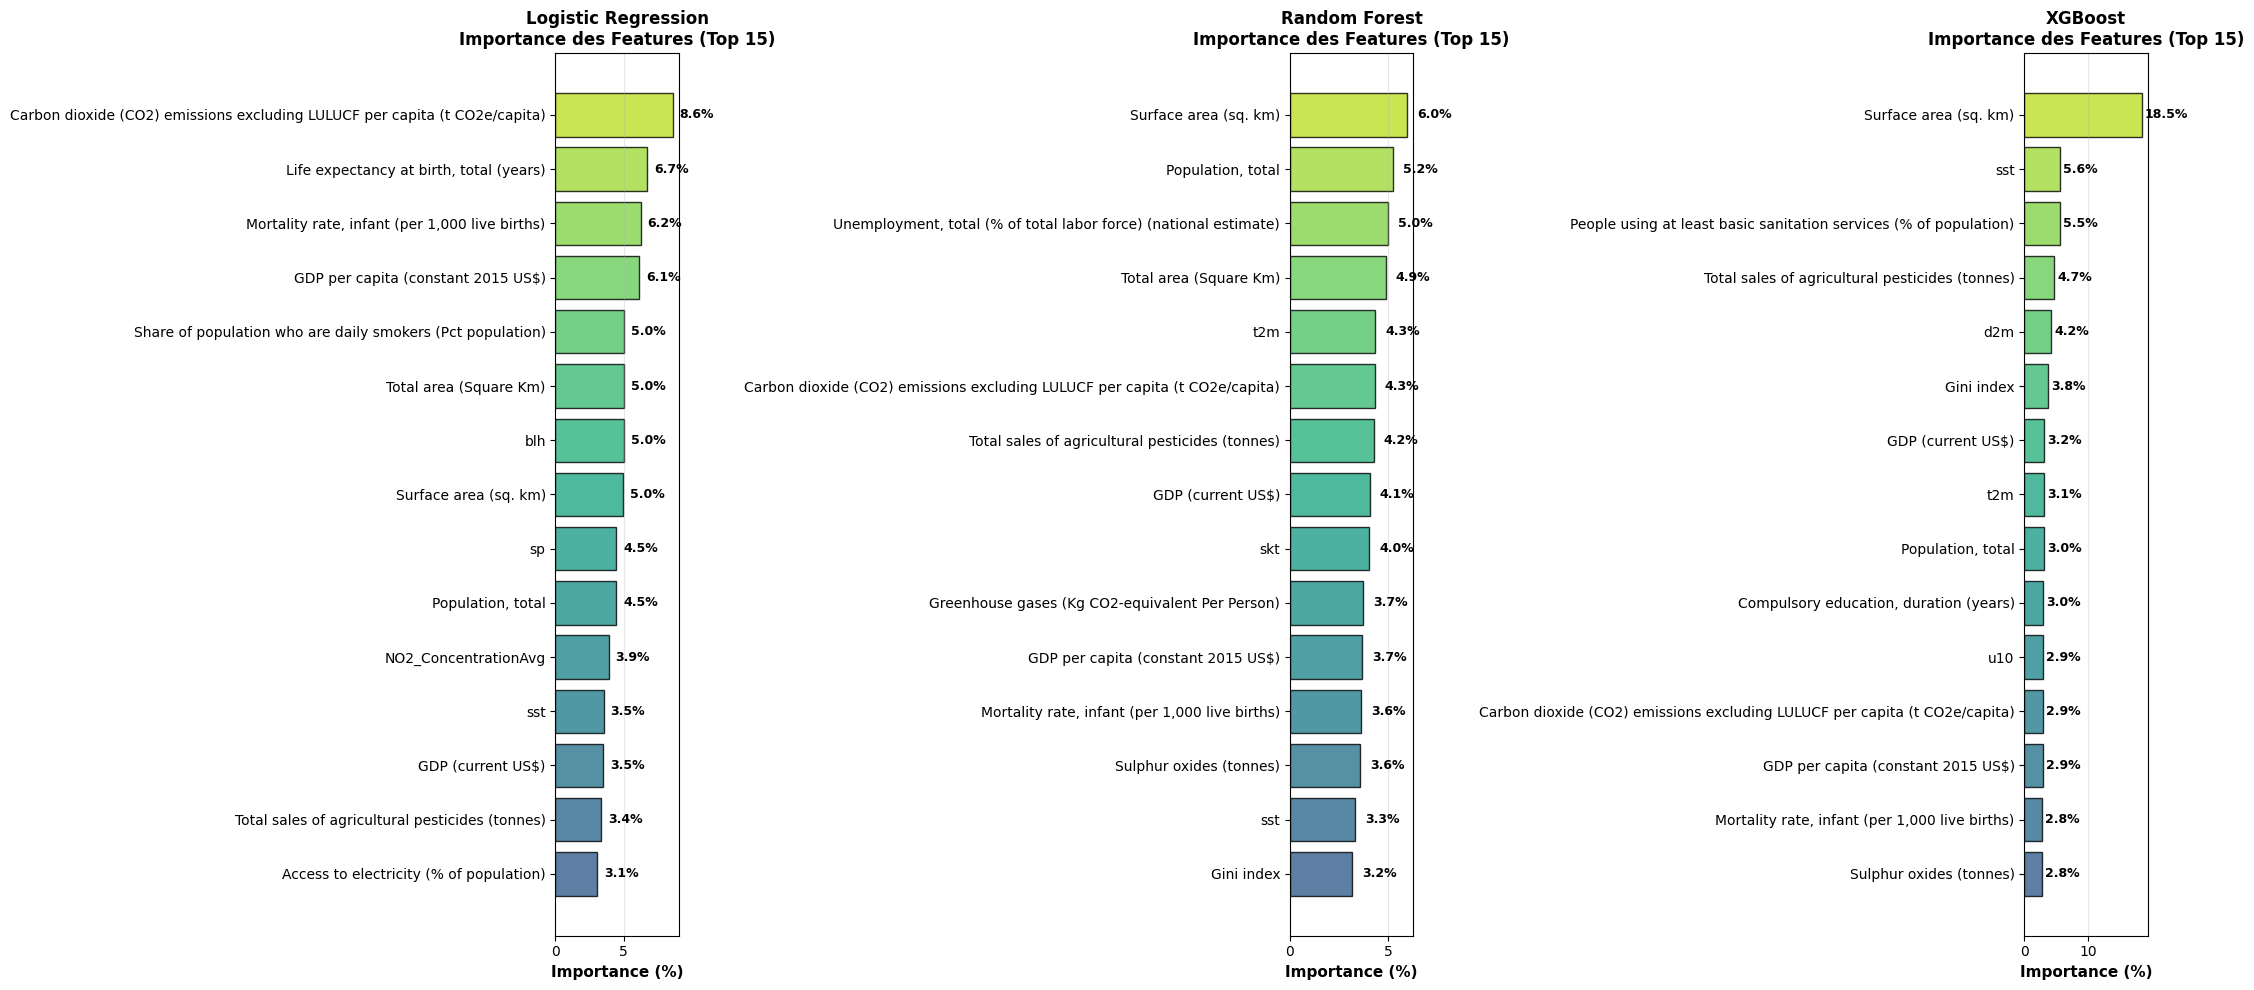

✓ Visualisation de l'importance des features (Top 15) créée


In [17]:
# Visualisation de l'importance des features (Top 15) pour chaque modèle

fig, axes = plt.subplots(1, 3, figsize=(22, 10)) 

for idx, (model_name, importances) in enumerate(feature_importances.items()):
    # Déterminer les noms de features à utiliser
    if len(importances) != len(feature_names):
        min_len = min(len(importances), len(feature_names))
        current_feature_names = feature_names[:min_len]
    else:
        current_feature_names = feature_names
    
    # Créer DataFrame et trier
    importance_df = pd.DataFrame({
        'Feature': current_feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(15) # Top 15
    
    # Inverser pour affichage horizontal
    importance_df = importance_df.sort_values('Importance', ascending=True)
    
    # Normaliser les importances en pourcentages
    total_importance = importances.sum() # Somme totale de TOUTES les features
    importance_pct = (importance_df['Importance'] / total_importance) * 100
    
    # Couleurs
    colors_palette = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
    
    # Créer le graphique horizontal
    bars = axes[idx].barh(importance_df['Feature'], importance_pct, 
                          color=colors_palette, alpha=0.8, edgecolor='black')
    
    axes[idx].set_xlabel('Importance (%)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{model_name}\nImportance des Features (Top 15)', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for bar, pct in zip(bars, importance_pct):
        width = bar.get_width()
        axes[idx].text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                      f'{pct:.1f}%', 
                      ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Visualisation de l'importance des features (Top 15) créée")
print("="*80)


In [18]:
# Comparaison de l'importance des features entre modèles

print("="*100)
print("COMPARAISON DE L'IMPORTANCE DES FEATURES ENTRE MODÈLES")
print("="*100)

# Déterminer le nombre de features à utiliser (prendre le minimum)
min_features = min(len(importances) for importances in feature_importances.values())
current_feature_names = feature_names[:min_features]

# Créer un DataFrame pour comparer les importances
comparison_data = {'Feature': current_feature_names}

for model_name, importances in feature_importances.items():
    # Normaliser en pourcentages (utiliser seulement les min_features premières)
    importances_subset = importances[:min_features]
    total = importances_subset.sum()
    pct = (importances_subset / total) * 100
    comparison_data[model_name] = pct

comparison_df = pd.DataFrame(comparison_data)

# Calculer la moyenne et l'écart-type
comparison_df['Moyenne'] = comparison_df[list(feature_importances.keys())].mean(axis=1)
comparison_df['Écart-type'] = comparison_df[list(feature_importances.keys())].std(axis=1)

# Trier par moyenne décroissante
comparison_df = comparison_df.sort_values('Moyenne', ascending=False)

print("\nTableau comparatif des importances (en %) - Top 15 :\n")
print(comparison_df.head(15).to_string(index=False))

print("\n" + "="*100)
print("📊 ANALYSE :")
print("="*100)

# Feature la plus importante en moyenne
most_important = comparison_df.iloc[0]
print(f"\n🏆 Feature la plus importante en moyenne : {most_important['Feature']}")
print(f"   Moyenne : {most_important['Moyenne']:.2f}%")

# Feature la moins importante en moyenne
least_important = comparison_df.iloc[-1]
print(f"\n📉 Feature la moins importante en moyenne : {least_important['Feature']}")
print(f"   Moyenne : {least_important['Moyenne']:.2f}%")

# Features avec le plus de consensus (faible écart-type)
consensus = comparison_df.nsmallest(3, 'Écart-type')
print(f"\n🎯 Features avec le plus de consensus entre modèles (faible écart-type) :")
for i, row in enumerate(consensus.iterrows(), 1):
    idx, data = row
    print(f"   {i}. {data['Feature']} (écart-type: {data['Écart-type']:.2f}%, moyenne: {data['Moyenne']:.2f}%)")

# Features avec le plus de divergence (fort écart-type)
divergence = comparison_df.nlargest(3, 'Écart-type')
print(f"\n⚠️ Features avec le plus de divergence entre modèles (fort écart-type) :")
for i, row in enumerate(divergence.iterrows(), 1):
    idx, data = row
    print(f"   {i}. {data['Feature']} (écart-type: {data['Écart-type']:.2f}%, moyenne: {data['Moyenne']:.2f}%)")

print("\n" + "="*100)


COMPARAISON DE L'IMPORTANCE DES FEATURES ENTRE MODÈLES

Tableau comparatif des importances (en %) - Top 15 :

                                                                   Feature  Logistic Regression  Random Forest   XGBoost  Moyenne  Écart-type
                                                     Surface area (sq. km)             4.950796       5.960717 18.460209 9.790574    7.525085
Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)             8.616626       4.327075  2.925202 5.289635    2.965294
                                                         Population, total             4.457148       5.243113  3.021485 4.240582    1.126536
                                        GDP per capita (constant 2015 US$)             6.133065       3.658828  2.922627 4.238173    1.681802
                            Mortality rate, infant (per 1,000 live births)             6.249933       3.623477  2.818260 4.230557    1.794576
                                      

### Interprétation des Features Importantes

Analysons la signification des features les plus importantes pour comprendre ce qui influence les prédictions.


In [19]:
# Interprétation détaillée des features

print("="*100)
print("INTERPRÉTATION DES FEATURES")
print("="*100)

# Description de chaque feature (mise à jour)
feature_descriptions = {
    'Year': 'Année (tendance temporelle)',
    'location_encoded': 'Pays/région encodé (effet géographique)',
    'Access to clean fuels and technologies for cooking (% of population)': 'Accès aux combustibles propres',
    'Access to electricity (% of population)': 'Accès à l\'électricité',
    'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)': 'Émissions de CO2 par habitant',
    'Compulsory education, duration (years)': 'Durée de l\'éducation obligatoire',
    'GDP (current US$)': 'PIB (total)',
    'GDP per capita (constant 2015 US$)': 'PIB par habitant',
    'Gini index': 'Indice de Gini (inégalités)',
    'Life expectancy at birth, total (years)': 'Espérance de vie',
    'Mortality rate, infant (per 1,000 live births)': 'Taux de mortalité infantile',
    'People using at least basic sanitation services (% of population)': 'Accès aux services sanitaires',
    'Population, total': 'Population totale',
    'Poverty headcount ratio at national poverty lines (% of population)': 'Taux de pauvreté',
    'Renewable electricity output (% of total electricity output)': 'Production d\'électricité renouvelable',
    'Surface area (sq. km)': 'Superficie',
    'Unemployment, total (% of total labor force) (national estimate)': 'Taux de chômage',
    'Total area (Square Km)': 'Superficie totale',
    'PM10_ConcentrationAvg': 'Concentration moyenne de PM10',
    'PM25_ConcentrationAvg': 'Concentration moyenne de PM2.5',
    'NO2_ConcentrationAvg': 'Concentration moyenne de NO2',
    'Greenhouse gases (Kg CO2-equivalent Per Person)': 'Émissions de gaz à effet de serre par personne',
    'Sulphur oxides (tonnes)': "Émissions d'oxydes de soufre",
    'Total sales of agricultural pesticides (tonnes)': 'Ventes de pesticides',
    'Share of population who are daily smokers (Pct population)': 'Pourcentage de fumeurs quotidiens',
    'u10': 'Composante U du vent (météo)',
    'v10': 'Composante V du vent (météo)',
    'd2m': 'Température du point de rosée (météo)',
    't2m': 'Température à 2m (météo)',
    'sst': 'Température de surface de la mer (météo)',
    'sp': 'Pression de surface (météo)',
    'skt': 'Température de la peau (météo)',
    'blh': 'Hauteur de la couche limite (météo)'
}

print("\n📋 DESCRIPTION DES FEATURES (Top 10) :\n")
for feature in comparison_df['Feature'].head(10):
    desc = feature_descriptions.get(feature, 'Description non disponible')
    mean_imp = comparison_df[comparison_df['Feature'] == feature]['Moyenne'].values[0]
    print(f"• {feature:<65} : {desc}")
    print(f"  {'':65}   Importance moyenne : {mean_imp:.2f}%")
    print()

print("="*100)
print("💡 CONCLUSION :")
print("="*100)
print("L'analyse d'importance montre quels facteurs environnementaux, économiques")
print("et sociaux sont les plus liés au taux de BPCO dans vos données.")
print("Ceci répond directement à l'objectif du projet.")
print("="*100)


INTERPRÉTATION DES FEATURES

📋 DESCRIPTION DES FEATURES (Top 10) :

• Surface area (sq. km)                                             : Superficie
                                                                      Importance moyenne : 9.79%

• Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) : Émissions de CO2 par habitant
                                                                      Importance moyenne : 5.29%

• Population, total                                                 : Population totale
                                                                      Importance moyenne : 4.24%

• GDP per capita (constant 2015 US$)                                : PIB par habitant
                                                                      Importance moyenne : 4.24%

• Mortality rate, infant (per 1,000 live births)                    : Taux de mortalité infantile
                                                                      Importa

In [20]:
# Export du DataFrame imputé pour éviter de refaire l'imputation à chaque fois
# L'imputation avec IterativeImputer prend beaucoup de temps

import os

# Créer un dossier pour les données prétraitées si nécessaire
output_dir = "preprocessed_data"
os.makedirs(output_dir, exist_ok=True)

# Définir les chemins de sortie
csv_path = os.path.join(output_dir, f"df_imputed_{folder_name}_{file_name}.csv")
parquet_path = os.path.join(output_dir, f"df_imputed_{folder_name}_{file_name}.parquet")

# Export en CSV
print(f"💾 Export en CSV : {csv_path}")
df_imputed.to_csv(csv_path, index=False)
print(f"✓ Exporté avec succès ({os.path.getsize(csv_path) / 1024:.2f} KB)")

# Export en Parquet (format plus compact et rapide)
print(f"\n💾 Export en Parquet : {parquet_path}")
df_imputed.to_parquet(parquet_path, index=False, engine='pyarrow')
print(f"✓ Exporté avec succès ({os.path.getsize(parquet_path) / 1024:.2f} KB)")

print(f"\n{'='*80}")
print("📌 UTILISATION :")
print("="*80)
print("Pour charger les données prétraitées la prochaine fois :")
print()
print("# Option 1 : CSV")
print(f"df_imputed = pd.read_csv('{csv_path}')")
print()
print("# Option 2 : Parquet (plus rapide et compact)")
print(f"df_imputed = pd.read_parquet('{parquet_path}')")
print()
print("# N'oubliez pas de recharger Y_class et Y_label depuis df original :")
print("df_imputed['Y_class'] = y_class_saved")
print("df_imputed['Y_label'] = y_label_saved")
print("="*80)

💾 Export en CSV : preprocessed_data/df_imputed_1021_COPD_prevalence_rate.csv
✓ Exporté avec succès (212.95 KB)

💾 Export en Parquet : preprocessed_data/df_imputed_1021_COPD_prevalence_rate.parquet
✓ Exporté avec succès (131.03 KB)

📌 UTILISATION :
Pour charger les données prétraitées la prochaine fois :

# Option 1 : CSV
df_imputed = pd.read_csv('preprocessed_data/df_imputed_1021_COPD_prevalence_rate.csv')

# Option 2 : Parquet (plus rapide et compact)
df_imputed = pd.read_parquet('preprocessed_data/df_imputed_1021_COPD_prevalence_rate.parquet')

# N'oubliez pas de recharger Y_class et Y_label depuis df original :
df_imputed['Y_class'] = y_class_saved
df_imputed['Y_label'] = y_label_saved
